In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
np.random.seed(42)

In [4]:
def generate_dataset(n_samples=500, noise_level=0.3):
    cgpa = np.random.uniform(0.3, 4.0, n_samples)
    
    sgpa = np.random.uniform(0.3, 4.0, n_samples)
    
    X = np.column_stack((cgpa, sgpa)) # stacks two 1D arrays into a 2D array
    
    initial_scores = 0.7*cgpa + 0.3*sgpa 
    y = np.where(initial_scores > 2.5, 1, 0)  # 1 for pass, 0 for fail
    boundary_distance = np.abs(initial_scores - 2.5)
    boundary_region = boundary_distance < noise_level
    flip_mask = np.logical_and(boundary_region, np.random.random(n_samples) < 0.5)
    y[flip_mask] = 1 - y[flip_mask]  # flipping the labels (0->1, 1->0)
    
    return X, y

In [5]:
X, y = generate_dataset(500)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(f"Dataset size: {X.shape[0]} samples")
print(f"Number of pass: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"Number of fail: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Dataset size: 500 samples
Number of pass: 184 (36.8%)
Number of fail: 316 (63.2%)
Training set size: 400 samples
Test set size: 100 samples


Number of overlapping points: 55 (11.0%)


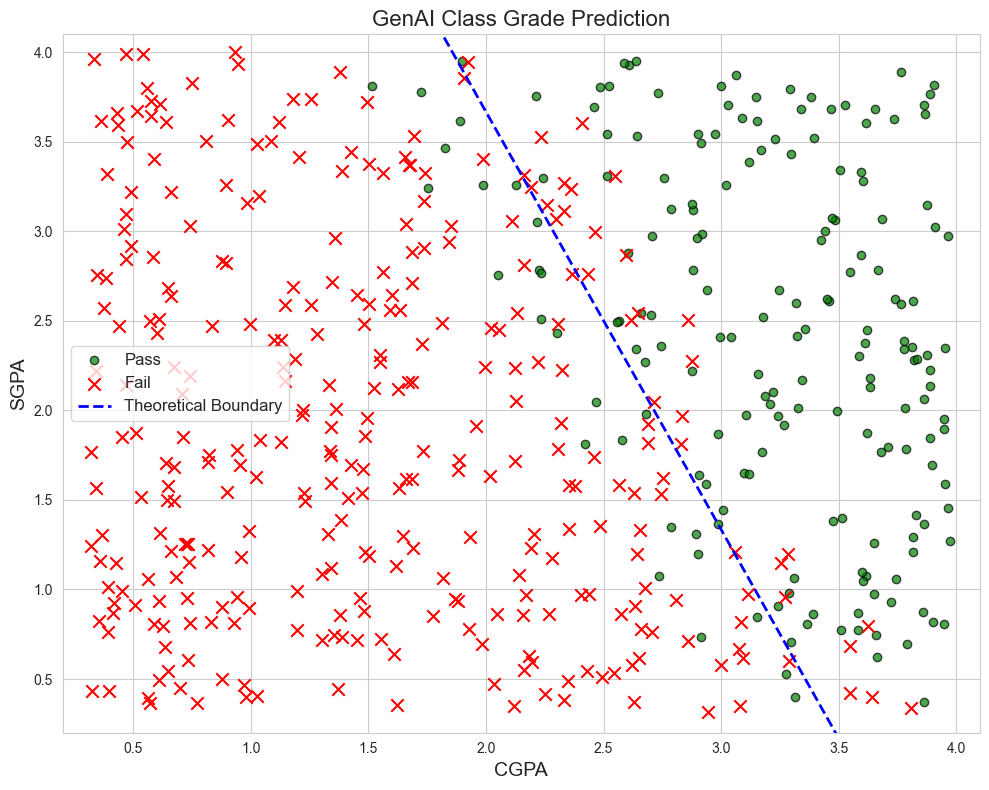

In [13]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

plt.scatter(X[y==1, 0], X[y==1, 1], c='green', marker='o', edgecolor='k', alpha=0.7, label='Pass')
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='x', s=80, label='Fail')

x_boundary = np.linspace(0.3, 4.0, 100)
y_boundary = (2.5 - 0.7*x_boundary) / 0.3
plt.plot(x_boundary, y_boundary, 'b--', linewidth=2, label='Theoretical Boundary')

plt.xlabel('CGPA', fontsize=14)
plt.ylabel('SGPA', fontsize=14)
plt.title('GenAI Class Grade Prediction', fontsize=16)
plt.legend(fontsize=12)

plt.xlim(0.2, 4.1)
plt.ylim(0.2, 4.1)

theoretical_y = np.where(0.7*X[:, 0] + 0.3*X[:, 1] > 2.5, 1, 0)
overlap_count = np.sum(theoretical_y != y)
print(f"Number of overlapping points: {overlap_count} ({overlap_count/len(y)*100:.1f}%)")

plt.tight_layout()
plt.show()

In [14]:
class Perceptron:
    def __init__(self, n_features):
        """
        Initialize the perceptron with random weights and bias
        
        Parameters:
        -----------
        n_features : int
            Number of input features
        """
        self.weights = np.random.randn(n_features) * 0.01 # initialize weights with small random numbers
        self.bias = np.random.randn() * 0.01  # initialize bias with small random number
        self.errors = []
        self.accuracies = []
        
    def step_function(self, x):
        """
        Step activation function
        
        Parameters:
        -----------
        x : float or numpy array
            Input to the activation function
            
        Returns:
        --------
        int or numpy array
            1 if x >= 0, 0 otherwise
        """
        return np.where(x >= 0, 1, 0)
    
    def forward_pass(self, X):
        """
        Compute forward pass: weighted sum and activation
        
        Parameters:
        -----------
        X : numpy array
            Input features, shape (n_samples, n_features)
            
        Returns:
        --------
        numpy array
            Predicted outputs after activation
        """
        weighted_sum = np.dot(X, self.weights) + self.bias #calculate weighted sum: w1*x1 + w2*x2 + ... + wn*xn + bias
        
        predictions = self.step_function(weighted_sum) #apply step function
        
        return predictions
    
    def backward_pass(self, X, y, predictions, learning_rate=0.01):
        """
        Compute the error and update weights using the delta rule
        
        Parameters:
        -----------
        X : numpy array
            Input features, shape (n_samples, n_features)
        y : numpy array
            Target values, shape (n_samples,)
        predictions : numpy array
            Predicted values from forward pass, shape (n_samples,)
        learning_rate : float
            Controls the step size for weight updates
            
        Returns:
        --------
        float
            Sum of squared errors
        """
        errors = y - predictions #calculate errors: true - predicted
        
        # update weights - delta rule: w_new = w_old + learning_rate * error * x
        for i in range(len(X)):
            if errors[i] != 0: # if error is 0, no need to update
                self.weights += learning_rate * errors[i] * X[i]
                self.bias += learning_rate * errors[i]
        
        return np.sum(errors**2) # sum of squared errors
    
    def train(self, X, y, n_epochs=100, learning_rate=0.01, early_stopping=True, patience=10, min_delta=0.01):
        """
        Train the perceptron with early stopping
        
        Parameters:
        -----------
        X : numpy array
            Training features, shape (n_samples, n_features)
        y : numpy array
            Target values, shape (n_samples,)
        n_epochs : int
            Maximum number of training epochs
        learning_rate : float
            Learning rate for weight updates
        early_stopping : bool
            Whether to use early stopping
        patience : int
            Number of epochs to wait for improvement before stopping
        min_delta : float
            Minimum change in error to be considered as improvement
            
        Returns:
        --------
        list
            Error for each epoch
        """
        self.errors = []
        self.accuracies = []
        
        # variables for early stopping
        best_error = float('inf')
        best_weights = self.weights.copy()
        best_bias = self.bias
        patience_counter = 0
        
        for epoch in range(n_epochs):
            predictions = self.forward_pass(X)
            
            error = self.backward_pass(X, y, predictions, learning_rate)
            
            accuracy = accuracy_score(y, predictions)
            
            self.errors.append(error)
            self.accuracies.append(accuracy)
            
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{n_epochs}, Error: {error:.4f}, Accuracy: {accuracy:.4f}")
            
            #early stopping logic
            if early_stopping:
                if error < best_error - min_delta:
                    # if we found better weights
                    best_error = error
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # should we stop ?
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    #restore best weights
                    self.weights = best_weights
                    self.bias = best_bias
                    break
        
        # If training completed without early stopping
        if epoch == n_epochs - 1:
            print(f"Training completed after {n_epochs} epochs")
        
        return self.errors, self.accuracies
    
    def predict(self, X):
        """
        Make predictions on new data
        
        Parameters:
        -----------
        X : numpy array
            Input features, shape (n_samples, n_features)
            
        Returns:
        --------
        numpy array
            Predicted class labels
        """
        return self.forward_pass(X)
    
    def decision_boundary(self, x):
        """
        Calculate the decision boundary for plotting
        
        Parameters:
        -----------
        x : numpy array
            Array of x-values
            
        Returns:
        --------
        numpy array
            Corresponding y-values for the decision boundary
        """
        #if w1*x1 + w2*x2 + bias = 0, then x2 = (-w1*x1 - bias) / w2
        return (-self.weights[0] * x - self.bias) / self.weights[1]

Epoch 1/200, Error: 235.0000, Accuracy: 0.4125
Epoch 10/200, Error: 176.0000, Accuracy: 0.5600
Epoch 20/200, Error: 171.0000, Accuracy: 0.5725
Epoch 30/200, Error: 170.0000, Accuracy: 0.5750
Epoch 40/200, Error: 147.0000, Accuracy: 0.6325
Epoch 50/200, Error: 140.0000, Accuracy: 0.6500
Epoch 60/200, Error: 124.0000, Accuracy: 0.6900
Epoch 70/200, Error: 117.0000, Accuracy: 0.7075
Epoch 80/200, Error: 90.0000, Accuracy: 0.7750
Epoch 90/200, Error: 90.0000, Accuracy: 0.7750
Epoch 100/200, Error: 90.0000, Accuracy: 0.7750
Epoch 110/200, Error: 79.0000, Accuracy: 0.8025
Epoch 120/200, Error: 77.0000, Accuracy: 0.8075
Early stopping at epoch 120


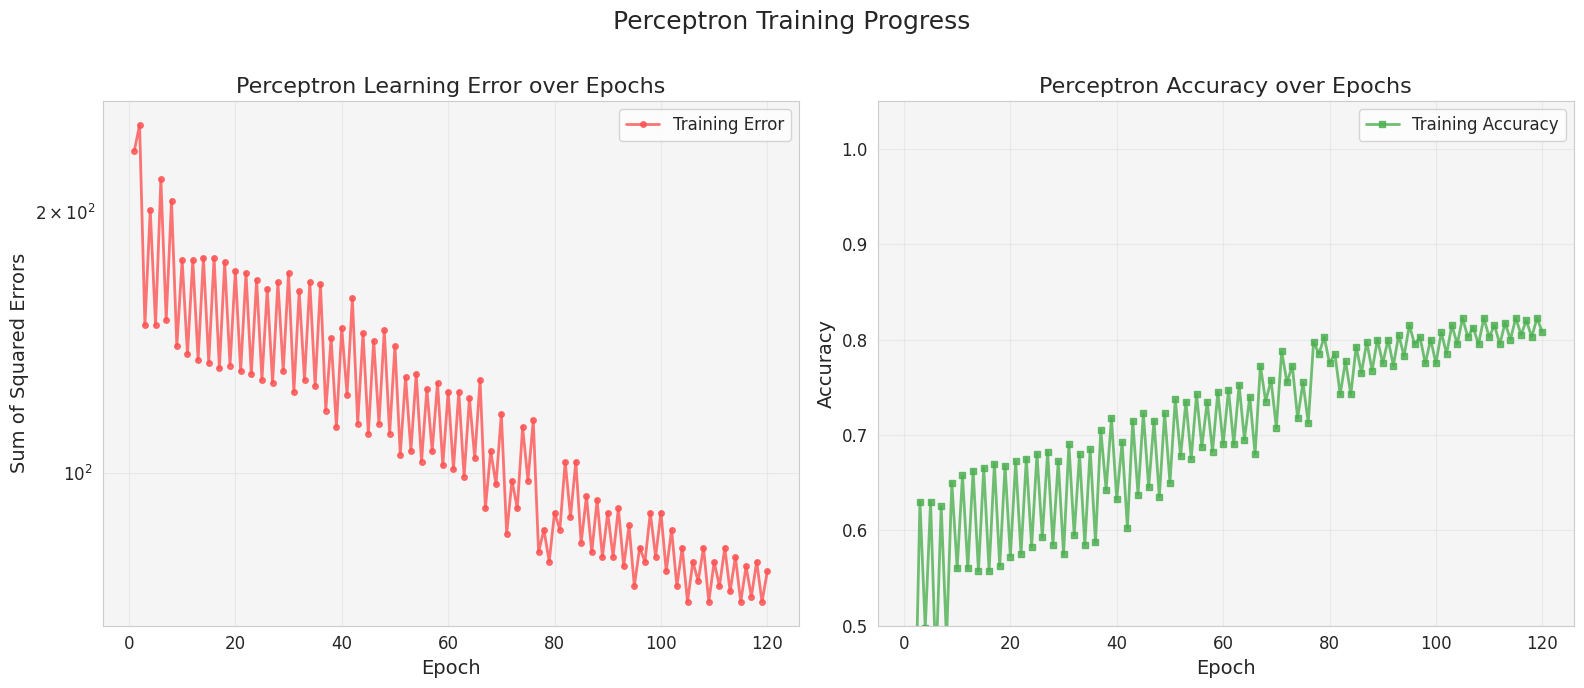

Final weights: [7.44639961 2.82416361]
Final bias: -20.27389572466801
Test accuracy: 0.8000


In [15]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

perceptron = Perceptron(n_features=2)
errors, accuracies = perceptron.train(X_train, y_train, n_epochs=200, learning_rate=0.01, 
                               early_stopping=True, patience=15, min_delta=0.001)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

epochs = range(1, len(errors) + 1)
ax1.plot(epochs, errors, color='#FF5252', marker='o', markersize=4, linestyle='-', linewidth=2,
         alpha=0.8, label='Training Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Sum of Squared Errors')
ax1.set_title('Perceptron Learning Error over Epochs')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f5f5f5')
ax1.legend()

ax2.plot(epochs, accuracies, color='#4CAF50', marker='s', markersize=4, linestyle='-', linewidth=2,
         alpha=0.8, label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Perceptron Accuracy over Epochs')
ax2.set_ylim(0.5, 1.05)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f5f5f5')
ax2.legend()

fig.suptitle('Perceptron Training Progress', fontsize=18, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

print(f"Final weights: {perceptron.weights}")
print(f"Final bias: {perceptron.bias}")

test_predictions = perceptron.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test accuracy: {test_accuracy:.4f}")

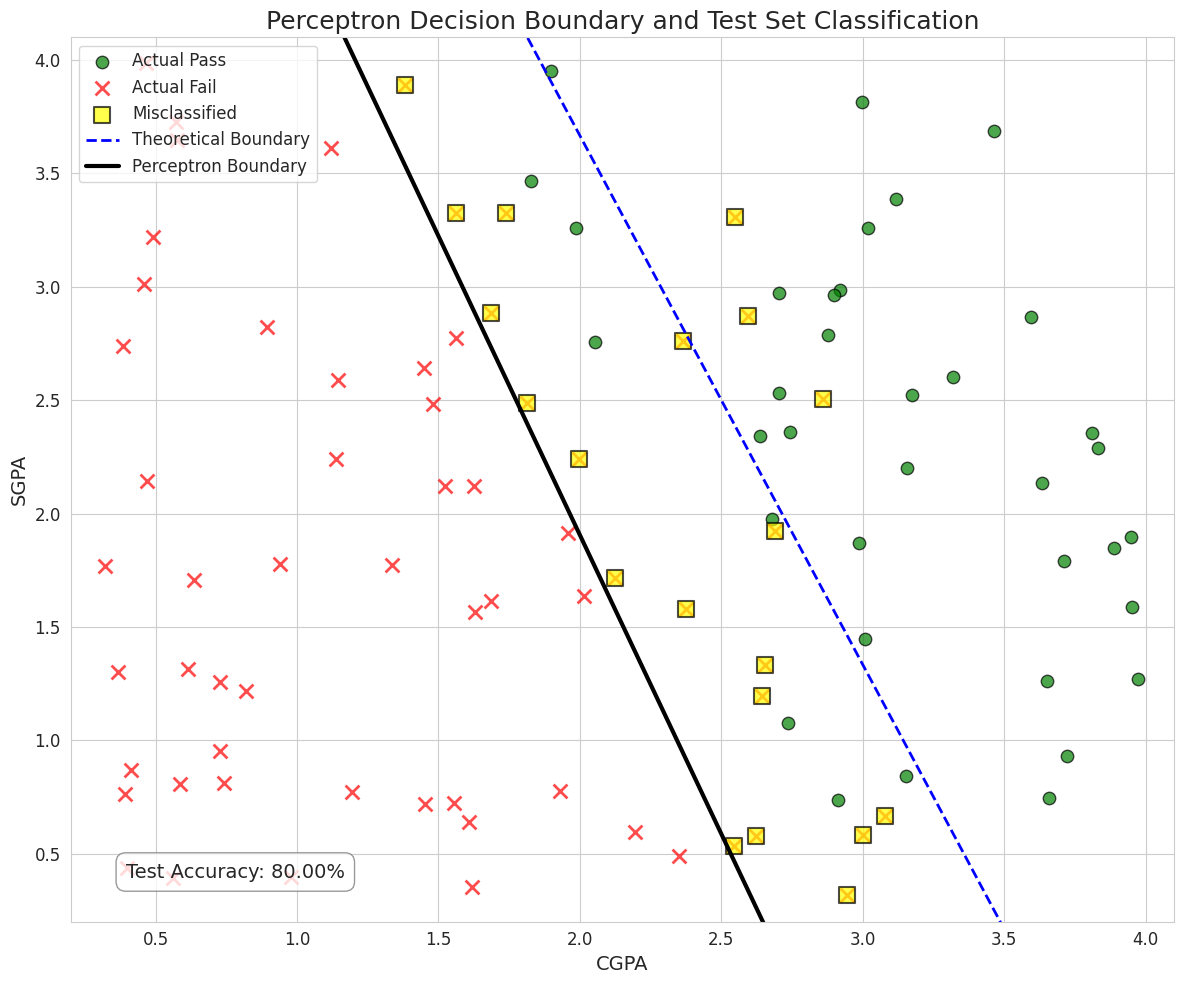

In [16]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

test_predictions = perceptron.predict(X_test)

test_accuracy = accuracy_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
class_report = classification_report(y_test, test_predictions)

plt.figure(figsize=(12, 10))

plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='green', marker='o', edgecolor='k', 
            alpha=0.7, s=80, label='Actual Pass')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='red', marker='x', 
            alpha=0.7, s=100, linewidth=2, label='Actual Fail')

misclassified = y_test != test_predictions
if np.any(misclassified):
    plt.scatter(X_test[misclassified, 0], X_test[misclassified, 1], c='yellow', marker='s', s=120,
               alpha=0.7, edgecolor='k', linewidth=1.5, label='Misclassified')

x_boundary = np.linspace(0.3, 4.0, 100)
y_boundary = (2.5 - 0.7*x_boundary) / 0.3
plt.plot(x_boundary, y_boundary, 'b--', linewidth=2, label='Theoretical Boundary')

x_decision = np.linspace(0.3, 4.0, 100)
try:
    y_decision = perceptron.decision_boundary(x_decision)
    plt.plot(x_decision, y_decision, 'k-', linewidth=3, label='Perceptron Boundary')
except:
    print("Warning: Could not plot decision boundary (possibly vertical or horizontal)")

plt.xlabel('CGPA', fontsize=14)
plt.ylabel('SGPA', fontsize=14)
plt.title('Perceptron Decision Boundary and Test Set Classification', fontsize=18)
plt.legend(fontsize=12, loc='upper left')

plt.xlim(0.2, 4.1)
plt.ylim(0.2, 4.1)

plt.annotate(f'Test Accuracy: {test_accuracy:.2%}', 
             xy=(0.05, 0.05), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
             fontsize=14)

plt.tight_layout()
plt.show()

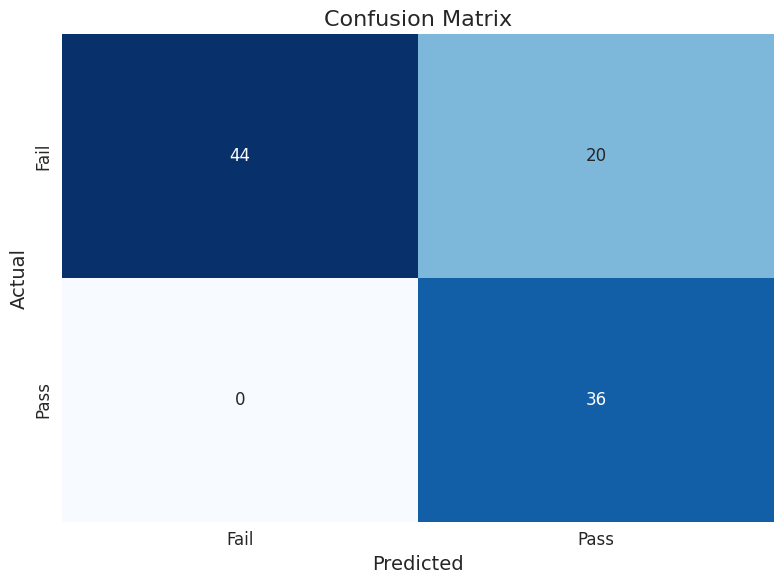

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [18]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        64
           1       0.64      1.00      0.78        36

    accuracy                           0.80       100
   macro avg       0.82      0.84      0.80       100
weighted avg       0.87      0.80      0.80       100



In [20]:
tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8000
Precision: 0.6429
Recall: 1.0000
Specificity: 0.6875
F1 Score: 0.7826


In [21]:
if precision > recall:
    print(f"The model has higher precision ({precision:.2%}) than recall ({recall:.2%}), "
          f"meaning it's more conservative in predicting passes and has fewer false positives.")
else:
    print(f"The model has higher recall ({recall:.2%}) than precision ({precision:.2%}), "
          f"meaning it's more likely to correctly identify passing students but may have more false positives.")

The model has higher recall (100.00%) than precision (64.29%), meaning it's more likely to correctly identify passing students but may have more false positives.


In [22]:
angle = np.arctan2(perceptron.weights[1], perceptron.weights[0]) * 180 / np.pi
theoretical_angle = np.arctan2(0.3, 0.7) * 180 / np.pi
angle_diff = abs(angle - theoretical_angle)

print(f"\nThe learned decision boundary has a slope that is {angle_diff:.2f} degrees different from the theoretical boundary.")
print("This difference is expected due to the overlapping nature of the dataset, which makes finding the exact theoretical boundary impossible.")


The learned decision boundary has a slope that is 2.43 degrees different from the theoretical boundary.
This difference is expected due to the overlapping nature of the dataset, which makes finding the exact theoretical boundary impossible.


In [ ]:
#calculate % of instances in the overlapping zone
boundary_distance = np.abs(0.7*X_test[:, 0] + 0.3*X_test[:, 1] - 2.5)
overlap_zone = boundary_distance < 0.3
overlap_pct = np.sum(overlap_zone) / len(X_test) * 100

print(f"\nApproximately {overlap_pct:.1f}% of the test instances are in the potential overlap zone near the boundary.")
print(f"The perceptron correctly classified {(np.sum(~misclassified & overlap_zone) / np.sum(overlap_zone) * 100):.1f}% of these difficult border cases.")


Approximately 25.0% of the test instances are in the potential overlap zone near the boundary.
The perceptron correctly classified 60.0% of these difficult border cases.
